Learnings

- Explore sklearn preprocessing tools
- Data processing takes forever


In [143]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [144]:
train_file = '/home/rushi/dev/data/housing/train.csv'
test_file = '/home/rushi/dev/data/housing/test.csv'
hd = pd.read_csv(train_file)

In [145]:
# parse the data dictionary

class Desc(object):
    def __init__(self, name, desc, desc_dict=None):
        self.desc_dict = desc_dict
        self.desc = desc
        self.name = name
        
    def add(self, val, val_desc):
        if self.desc_dict is None:
            self.desc_dict = {}
        self.desc_dict[val] = str(val) + '_' + val_desc
        
    def __repr__(self):
        ret = f'{self.name}: {self.desc} Quant: {self.desc_dict is None} '
        if self.desc_dict is not None:            
            ret +='\n'
            ret +='\n'.join([f'{k}: {v}' for k,v in self.desc_dict.items()])
        return ret
        
data_txt_file = '/home/rushi/dev/data/housing/data_description.txt'

data_dict = {}
data_dict['Id'] = Desc('Id', 'Index')
with open(data_txt_file, 'r') as f:
    curr_col = None
    for line in f.readlines():
        
        if line.strip() == '':
            # empty lines
            continue
            
        elif ':' in line.split(' ')[0]:
            # we are in a new column/description
            col_name, col_desc = line.split(':')
            curr_col = col_name
            data_dict[curr_col] = Desc(col_name, col_desc)
            
        else:
            # we are in column details
            line_splits = line.strip().split('\t')            
            val, val_desc = line_splits[0].strip(), ' '.join(line_splits[1:])            
            data_dict[curr_col].add(val, val_desc)

data_dict['SalePrice'] = Desc('SalePrice', 'Y')
cols = list(data_dict.keys())

assert len(data_dict) == len(hd.columns)
for v1, v2 in zip(data_dict.keys(), hd.columns):
    assert v1 == v2, (v1, v2)

In [146]:
import functools

def one_hot_encode(x, keys):
    x = str(x)
    res = np.zeros(len(keys))
    try:
        res[keys.index(x)] = 1
    except:
        # data has both of these descriptions.
        exceptions_map = {'C (all)' : 'C', 'Wd Shng': 'WdShing', 'WdShngl': 'WdShing',
                         'CmentBd' : 'CemntBd', 'Brk Cmn' : 'BrkComm', 'NA': 'None'}
        if x in exceptions_map.keys():
            x = exceptions_map[x]
    
        try:
            res[keys.index(x)] = 1
        except:
            # all zeros
            pass
    return res

converters_v1 = {}

for name, pred in data_dict.items():
    if pred.desc_dict is not None:  
       
        # create one hot encoding for qualitative inputs        
        keys = list(pred.desc_dict.keys())
        converters_v1[name] = functools.partial(one_hot_encode, keys=keys)
nhd = pd.read_csv(train_file, converters=converters_v1)

In [147]:
from itertools import repeat

# TODO: use basic target encoding
# TODO: Lookup bayesian target encoding

def ordinal_encode(x, keys):    
    return keys.index(x)

ordinal_keys = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
                'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
                'GarageQual', 'GarageCond', 'PoolQC'] + ['BsmtFinType1', 'BsmtFinType2', 'GarageFinish']

converters_v2 = {}

is_one_hot = []  # Bad name. should be is_not_one_hot
for name, pred in data_dict.items():
    
    if pred.desc_dict is not None:  
        
        # create one hot encoding for qualitative inputs        
        
        if name in ordinal_keys:            
            # reversed iterators since the values look [Good, Avg, Bad] and we want higher values for better quality
            # i.e we want +ve correlations with these predictors
            keys = list(reversed(list(pred.desc_dict.keys()) + ["NA"])) # Some test data does not have values
            converters_v2[name] = functools.partial(ordinal_encode, keys=keys)
            is_one_hot.append(1)
        else:
            keys = list(pred.desc_dict.keys())        
            converters_v2[name] = functools.partial(one_hot_encode, keys=keys)
            is_one_hot.extend([0] * len(keys))
    else:
        is_one_hot.append(1)

nhd_v2 = pd.read_csv(train_file, converters=converters_v2)
nhd_test = pd.read_csv(test_file, converters=converters_v2)

In [148]:
# Important: Convert to np arrays
def get_fdata(np_array):    
    rows = []
    for ii in np_array:
        row = np.array([], dtype=np.float64)
        for jj in ii:
            row = np.append(row, jj)
        rows.append(row)        
    return rows

fdata = np.concatenate([get_fdata(nhd.to_numpy())])
fdata_v2 = np.concatenate([get_fdata(nhd_v2.to_numpy())])
fdata_test = np.concatenate([get_fdata(nhd_test.to_numpy())])
fdata.shape, fdata_v2.shape, fdata_test.shape

((1460, 356), (1460, 274), (1459, 273))

In [149]:
# Get full axis values
full_axis = []
for key, value in data_dict.items():
    if value.desc_dict is not None:
        full_axis.extend([f'{key}_{x}'.replace(' ', '_') for x in value.desc_dict.values()])
    else:
        full_axis.append(value.name)
full_axis = np.array(full_axis)
print(full_axis[:5], full_axis.shape)

['Id' 'MSSubClass_20_1-STORY_1946_&_NEWER_ALL_STYLES'
 'MSSubClass_30_1-STORY_1945_&_OLDER'
 'MSSubClass_40_1-STORY_W/FINISHED_ATTIC_ALL_AGES'
 'MSSubClass_45_1-1/2_STORY_-_UNFINISHED_ALL_AGES'] (356,)


In [150]:
# Get full axis values v2
full_axis_v2 = []
for key, value in data_dict.items():
    if value.desc_dict is not None and key not in ordinal_keys:
        full_axis_v2.extend([f'{key}_{x}'.replace(' ', '_') for x in value.desc_dict.values()])
    else:
        full_axis_v2.append(value.name)
full_axis_v2 = np.array(full_axis_v2)
print(full_axis_v2[:5], full_axis_v2.shape)

['Id' 'MSSubClass_20_1-STORY_1946_&_NEWER_ALL_STYLES'
 'MSSubClass_30_1-STORY_1945_&_OLDER'
 'MSSubClass_40_1-STORY_W/FINISHED_ATTIC_ALL_AGES'
 'MSSubClass_45_1-1/2_STORY_-_UNFINISHED_ALL_AGES'] (274,)


In [234]:
def manual_clean(data, x_axis, is_train=True):
    # Replace index with intercept
    x = data[:,:-1].copy() if is_train else data.copy()# remove y
    x[:,0] = np.ones(x.shape[0]) # replace index with intercept
    data_dict['Id'] = Desc('Intercept', 'Intercept')
    data_dict['Id']
    x_axis = x_axis[:-1] # remove y 
    y = fdata[:,-1].copy() if is_train else None

    # MANUAL CLEANING
    lot_frontage_idx = x_axis.tolist().index('LotFrontage')
    mas_vnr_idx = x_axis.tolist().index('MasVnrArea')
    gbuilt_idx = x_axis.tolist().index('GarageYrBlt')
    ybuilt_idx = x_axis.tolist().index('YearBuilt')
    x[np.isnan(x[:, lot_frontage_idx]), lot_frontage_idx] = 0 # set lot frontage to 0 when unavailable
    x[np.isnan(x[:, mas_vnr_idx]), mas_vnr_idx] = 0 # set masonry veneer area to 0 when unavailable
    x[:, gbuilt_idx] = np.where(np.isnan(x[:, gbuilt_idx]), x[:, ybuilt_idx], x[:, gbuilt_idx]) # when garage built year unknown, use year property built
    
    return x, y, x_axis

x_v1, y_v1, axis_v1 = manual_clean(fdata, full_axis)
x_v2, y_v2, axis_v2 = manual_clean(fdata_v2, full_axis_v2)
x_test, y_test, axis_rtest = manual_clean(fdata_test, full_axis_v2, is_train=False)

In [235]:
# VIEW data
def dr(data, axis): # describe row
    return {x: v for x,v in zip(axis, data)}

In [236]:
def split_data(x, y):    
    test_idx = int(x.shape[0] * 0.8) + 1
    x_train = x[:test_idx, : ]
    y_train = y[:test_idx]
    x_test = x[test_idx:, :]
    y_test = y[test_idx:]
    
    return x_train, y_train, x_test, y_test

x1_train, y1_train, x1_test, y1_test = split_data(x_v1, y_v1)
x2_train, y2_train, x2_test, y2_test = split_data(x_v2, y_v2)

# Normalized data

# Data Version 3 is normalized values for quantitative X values
# Y is scaled down by 1e4
y3_scale = 1e4
y_v3 = y_v2.copy() / y3_scale

x_v3 = x_v2.copy()
axis_v3 = axis_v2.copy()

is_one_hot_np = np.array(is_one_hot[:-1]) # ignore intercept column for one_hot and y column
quant_indices = np.where(is_one_hot_np > 0)
quant_indices_x = quant_indices[0][1:]
assert (is_one_hot_np.shape[0] == x_v2.shape[1])

def normalize_all(x_o, x_train):
    x = x_o.copy()
    for idx in quant_indices_x:        
        x[:, idx] = (x[:, idx] - np.mean(x_train[:, idx]))/np.sqrt((np.var(x_train[:, idx])))
    return x

x3_train_o, y3_train, x3_test_o, y3_test = split_data(x_v3, y_v3)

x3_train = normalize_all(x3_train_o, x3_train_o)
x3_test = normalize_all(x3_test_o, x3_train_o)

# Normalize test data
x_rtest = normalize_all(x_test, x3_train_o)

# clean test data  # TODO: Check if OK
x_rtest[np.isnan(x_rtest)] = 0

# shape test
print(x3_train.shape, x_rtest.shape)

# Normalization Test
idx = axis_v3.tolist().index('GrLivArea')
print(np.sum(x3_train[:, idx]), np.sum(x3_test[:, idx]), np.sum(x_rtest[:, idx]))

(1169, 273) (1459, 273)
1.3145040611561853e-13 37.09446025822451 -47.67311227516237


In [237]:
from sklearn import linear_model

# Fit on a single variable
lot_frontage_idx = full_axis.tolist().index('LotFrontage')
LR = linear_model.LinearRegression(fit_intercept=False)
x1_train_int = x1_train[:, [0,lot_frontage_idx]]
res = LR.fit(x1_train_int, y1_train)
print(f"Coef: {res.coef_}")
print("Train score: {} Test score: {}".format(res.score(x1_train_int, y_train), res.score(x1_test[:, [0, lot_frontage_idx]], y1_test)))

# Fit on everything
LR = linear_model.LinearRegression(fit_intercept=False)
res_full_fit = LR.fit(x1_train, y1_train)
res_full_fit.score(x1_test, y1_test)
print("Train score: {} Test score: {}".format(res_full_fit.score(x1_train, y1_train), res_full_fit.score(x1_test, y1_test)))

Coef: [150462.09068574    523.28709799]
Train score: 0.051491390319412966 Test score: 0.013990042282039816
Train score: 0.9395495195087282 Test score: 0.6633091689051294


In [238]:
import scipy.stats
def get_corrs(x,y):

    # Find the most correlated variables
    def corr(x):
        return scipy.stats.pearsonr(x, y)
    corrs = np.apply_along_axis(corr, 0, x).T
    corrs[np.isnan(corrs)] = 0
    corrs = corrs[:,0] # ignore the p value
    return corrs

corrs = get_corrs(x1_train, y1_train)
corrs_v2 = get_corrs(x2_train, y2_train)
corrs_v3 = get_corrs(x3_train, y3_train)

# largest corrs
largest_corrs = np.argsort(-np.abs(corrs)) # -corrs since argsort sorts from min to max and we want largest corr
largest_corrs_v2 = np.argsort(-np.abs(corrs_v2))
largest_corrs_v3 = np.argsort(-np.abs(corrs_v3))

#dr(corrs[largest_corrs], axis_v1[largest_corrs])
#dr(corrs_v2[largest_corrs_v2], axis_v2[largest_corrs_v2])
#dr(corrs_v3[largest_corrs_v3], axis_v3[largest_corrs_v3])

/home/rushi/dev/git/python/environment/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [239]:
def fit(x_train, y_train, x_test, y_test):
    LR = linear_model.LinearRegression(fit_intercept=True)
    res = LR.fit(x_train, y_train)    
    return res.score(x_train, y_train), res.score(x_test, y_test), res

print("base top 20", fit(x1_train[:, largest_corrs[:20]], y1_train, x1_test[:, largest_corrs[:20]], y1_test))
print("v2 top 20", fit(x2_train[:, largest_corrs_v2[:20]], y2_train, x2_test[:, largest_corrs_v2[:20]], y2_test))
print("v2 top 140", fit(x2_train[:, largest_corrs_v2[:140]], y2_train, x2_test[:, largest_corrs_v2[:140]], y2_test))

print("v3 top 20", fit(x3_train[:, largest_corrs_v3[:20]], y3_train, x3_test[:, largest_corrs_v3[:20]], y3_test))
print("v3 top 140", fit(x3_train[:, largest_corrs_v3[:140]], y3_train, x3_test[:, largest_corrs_v3[:140]], y3_test))

print("v2 all", fit(x2_train, y2_train, x2_test, y2_test)) # TODO: needs explanation
print("v3 all", fit(x3_train, y3_train, x3_test, y3_test)) # TODO: needs explanation

# Look at the coeffecients since it gives information about actual influece in a combined setting.
# Especially since all of the inputs are now normalized.
#num_preds = None
#_,_,res = fit(x3_train[:, largest_corrs_v3[:num_preds]], y3_train, x3_test[:, largest_corrs_v3[:num_preds]], y3_test)
#dr(res.coef_, axis_v3[largest_corrs_v3[:num_preds]]), res.intercept_
# The coeffecients explode after the first  20 or so predictors.
# This is likely because they are heavily offset by the other predictors in the one-hot group.

base top 20 (0.8357951195579905, 0.633514671565675, LinearRegression())
v2 top 20 (0.8262935096544097, 0.6575572381355508, LinearRegression())
v2 top 140 (0.9083324699290795, 0.7096104843892723, LinearRegression())
v3 top 20 (0.8262935096544098, 0.6575572381355501, LinearRegression())
v3 top 140 (0.9077744307987841, 0.7108541562776536, LinearRegression())
v2 all (0.9253331622758502, -5236938.480691137, LinearRegression())
v3 all (0.9253371712961918, -7.447342444841612e+17, LinearRegression())


In [240]:
import os
from datetime import datetime 

def write_data(y, prefix):
    upload_dir = '/home/rushi/dev/data/housing/upload'
    #os.makedirs(upload_dir)
    timestamp = datetime.now().strftime('%Y%m%d.%H%M%S')    
    file_name = os.path.join(upload_dir, f'{prefix}_{timestamp}')
    print("Writing to ", file_name)
    with open(file_name, 'w') as f:
        f.write('Id,SalePrice\n')
        for idx, val in zip(fdata_test[:,0], y):
            f.write(f'{int(idx)},{val}\n')
    return file_name

In [241]:
# TODO: Can we weight these observations somehow ?

def regress(x, y, reg_lambda=0):
    xT = x.T
    xTx = xT @ x
    xTy = xT @ y
    #xTx_inv = np.linalg.solve(xTx, np.eye(xTx.shape[0])) # singular
    xTx_inv  = np.linalg.solve(xTx + reg_lambda * np.eye(xTx.shape[0]), np.eye(xTx.shape[0])) # regularized
    B = xTx_inv @ xTy
    return B, xTx_inv

# yhat = xTy
def pred(B, x):
    return x @ B

# R^2 score
def r2(yhat, y):
    tss = np.sum((y - np.mean(y)) ** 2)
    rss = np.sum((yhat - y) ** 2)
    return 1 - (rss/tss)

# sigma_squared_hat (noise variance estimate - mean 0)
def est_noise_var(y, yhat, num_samples, num_preds):
    return 1/(num_samples - num_preds - 1) * np.sum((y - yhat) ** 2)

def z_scores(B, B_var):
    return B/np.sqrt(np.diag(xTx_inv))

def metrics(y, yhat, scale=1):
    y = y * scale
    yhat = yhat * scale
    mse = np.sum((y - yhat)**2)/y.shape[0]
    base_rate = np.sum((y - np.mean(y))**2)/y.shape[0]
    mean_abs_error = np.sum(np.abs(y - yhat))/y.shape[0]
    return {'mse' : mse,
            'base_rate' : base_rate,
            'reduction' : 100 * (base_rate - mse)/base_rate,
            'mae' : mean_abs_error
           }

In [251]:
# Train using manual process and all preds

from IPython.display import display
B, xTx_inv = regress(x3_train, y3_train, 0.0001)

yhat_test = pred(B, x3_test)
yhat_train = pred(B, x3_train)
noise_var = est_noise_var(y3_train, yhat_train, x3_train.shape[0], x3_train.shape[1])
B_var = xTx_inv * noise_var
z_s = z_scores(B, B_var)
print("R2 score: Test: {} Train: {}".format(r2(yhat_test, y3_test), r2(yhat_train, y3_train)))
print("Noise Var: ", noise_var)
print("Train Metrics: {}\nTest Metrics: {}".format(metrics(y3_train, yhat_train), metrics(y3_test, yhat_test)))

R2 score: Test: 0.6649914615714716 Train: 0.9253331618764244
Noise Var:  6.050317963635546
Train Metrics: {'mse': 4.632193821602921, 'base_rate': 62.03816765264016, 'reduction': 92.53331618764246, 'mae': 1.441586189272393}
Test Metrics: {'mse': 22.508604709919936, 'base_rate': 67.18815232442792, 'reduction': 66.49914615714715, 'mae': 2.217755850577529}


In [255]:
# write the all preds solution to disk
y_rtest = np.maximum(0, pred(B, x_rtest) * y3_scale)
write_data(y_rtest, prefix='normalized_all_preds')

Writing to  /home/rushi/dev/data/housing/upload/normalized_all_preds_20211222.120633


'/home/rushi/dev/data/housing/upload/normalized_all_preds_20211222.120633'

In [258]:
!cat '/home/rushi/dev/data/housing/upload/normalized_all_preds_20211222.120633'

Id,SalePrice
1461,124417.677526597
1462,145706.08696248606
1463,180661.36981397413
1464,187149.82837961602
1465,217510.31043628996
1466,165952.74789316923
1467,169204.82936206507
1468,154258.22536133457
1469,203999.24702583274
1470,112323.88680222293
1471,179813.27674914282
1472,103209.4870933983
1473,99213.45303865068
1474,145304.67195211377
1475,106058.50732278865
1476,358684.03021695104
1477,286422.6393297503
1478,302792.1997739201
1479,301641.505504396
1480,457253.5528691612
1481,318516.93634749355
1482,221263.9882222006
1483,179027.4901861286
1484,165518.40234485827
1485,185399.49525699092
1486,199493.9737543797
1487,326742.335896589
1488,239745.67882247706
1489,215273.21078390075
1490,250836.1587811796
1491,210369.68621043395
1492,110957.10721733101
1493,179395.10115237185
1494,303302.6773414123
1495,283789.33136501967
1496,232718.50228094988
1497,164192.1383023579
1498,167516.05270982298
1499,152359.45655640855
1500,138068.337618645
1501,196562.75684945105
1502,124729.1152321868

In [243]:
# Predictors with Z scores with p<0.05
import scipy.stats
T_dist = scipy.stats.t(df = x_train.shape[0])
z_good_indices = np.where(np.abs(z_s) > T_dist.isf(0.05))[0]
print("Num good indices: ", len(z_good_indices))
dr(zip(B[z_good_indices], z_s[z_good_indices]), axis_v3[z_good_indices])

Num good indices:  31


{'LotFrontage': (0.0854609723284161, 2.148402218909648),
 'LotArea': (0.5966215018988059, 11.467397018608555),
 'OverallQual': (1.0291921503603167, 14.660848885199876),
 'OverallCond': (0.621935465442716, 12.760760642547845),
 'YearBuilt': (0.8671272823932696, 6.856054365541266),
 'YearRemodAdd': (0.11793626665957468, 2.0418626299311895),
 'MasVnrArea': (0.5043445892040956, 9.831499377483492),
 'ExterQual': (0.18628989757184666, 3.122579660223037),
 'ExterCond': (-0.08642373564942174, -2.263144080456449),
 'BsmtQual': (0.4790828501119957, 5.79142840442597),
 'BsmtCond': (-0.5650652907851539, -8.015243571307392),
 'BsmtExposure': (0.4517324832789309, 9.780244197350882),
 'HeatingQC': (0.12885340467230577, 2.812858805248398),
 'FullBath': (0.23765444277182046, 3.946518323444216),
 'HalfBath': (0.15407660254809796, 2.8998183496441263),
 'BedroomAbvGr': (-0.5698140440620962, -9.993688869773928),
 'KitchenAbvGr': (-0.3629129186081458, -5.574203166231138),
 'KitchenQual': (0.4487776405862762

In [244]:
# Implement forward selection

def forward_select(x, y, x_test, y_test, axis, reg=0.0001):
    model_indices = []
    candidate_indices = list(range(x.shape[1]))
    
    final_coefs = None  
    final_loss = None
    loss_list = []
    
    while len(candidate_indices) > 0:
        
        least_loss = None
        least_loss_idx = None
        for idx in candidate_indices:
            
            curr_pred_indices = model_indices + [idx]
            B, _  = regress(x[:, curr_pred_indices], y, reg)
            yhat_test = pred(B, x_test[:, curr_pred_indices])
            curr_metrics = metrics(y_test, yhat_test)
            
            loss = curr_metrics['mse']
            if not least_loss or loss < least_loss:
                least_loss_idx = idx
                least_loss = loss
                final_coefs = B            
        
        if not len(loss_list) or least_loss < loss_list[-1]:
            #print(f"Selected pred: {axis[least_loss_idx]} with least loss: {least_loss}")
            model_indices.append(least_loss_idx)
            candidate_indices.remove(least_loss_idx)
            loss_list.append(least_loss)            
        else:
            break
        
    return model_indices, final_coefs, loss_list

model_indices, final_coefs, loss_list = forward_select(x3_train, y3_train, x3_test, y3_test, axis_v3)

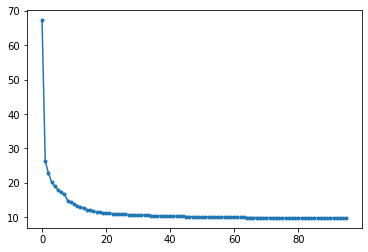

In [245]:
#display(dr(zip(final_coefs), axis_v3[model_indices]))
plt.plot(loss_list, '.-')

In [247]:
# Select the top 40 preds (via manual inspection - TODO: Use the standard error and choose the smallest model within a single standard deviation of the error rate)
num_preds = 40
coefs = final_coefs[:num_preds]
best_indices = model_indices[:num_preds]

# Use them for forecasting the train and validation data:
yhat_train = pred(coefs, x3_train[:, best_indices])
yhat_test = pred(coefs, x3_test[:, best_indices])
print("Train metrics : {} ".format(metrics(y3_train, yhat_train, scale=y3_scale)))
print("Test metrics : {} ".format(metrics(y3_test, yhat_test, scale=y3_scale)))

# Forecast real test data
yhat_rtest = pred(coefs, x_rtest[:, best_indices])

# scale yhat
yhat_rtest = np.maximum(0, yhat_rtest * y3_scale)

print("NaNs in output: ", np.where(np.isnan(yhat_rtest)))

# write to disk
file_name = write_data(yhat_rtest, prefix='forward_sel')

Train metrics : {'mse': 1198711858.572373, 'base_rate': 6203816765.264016, 'reduction': 80.67783263225765, 'mae': 23698.946302621374} 
Test metrics : {'mse': 1033326866.6482626, 'base_rate': 6718815232.442791, 'reduction': 84.62040060785283, 'mae': 21037.868385176153} 
NaNs in output:  (array([], dtype=int64),)
Writing to  /home/rushi/dev/data/housing/upload/forward_sel_20211222.114148


In [248]:
!cat $file_name

Id,SalePrice
1461,100759.61334002722
1462,173403.18977425917
1463,150260.34978365156
1464,187441.92968892062
1465,195260.4531132268
1466,167354.7465417423
1467,153237.32941255788
1468,153898.76071440114
1469,241160.00405962407
1470,113317.80539512126
1471,190481.53131063425
1472,89051.42992124514
1473,73016.33044550133
1474,147691.9496840901
1475,113576.02907629168
1476,316291.7781780126
1477,263273.6142653327
1478,332095.0730303284
1479,352526.17374443106
1480,389253.41642757045
1481,314295.28033663053
1482,268179.9233773501
1483,160080.8043660655
1484,198803.21835128366
1485,221805.91029014217
1486,205595.36236860766
1487,311800.7310221098
1488,207488.1662589818
1489,194058.48649728036
1490,187072.80082092356
1491,210303.8680296933
1492,84835.63778462948
1493,223880.24918871603
1494,302331.0596102204
1495,297010.7524213656
1496,226131.1996696144
1497,173950.65309427909
1498,194313.2412260742
1499,158314.1533803666
1500,140597.05567620514
1501,163521.9530191768
1502,170648.69150737533

(array([11., 39., 83., 64., 29., 25., 20.,  6.,  3.,  6.,  1.,  2.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 52500.,  87125., 121750., 156375., 191000., 225625., 260250.,
        294875., 329500., 364125., 398750., 433375., 468000., 502625.,
        537250., 571875., 606500., 641125., 675750., 710375., 745000.]),
 <a list of 1 Patch objects>)

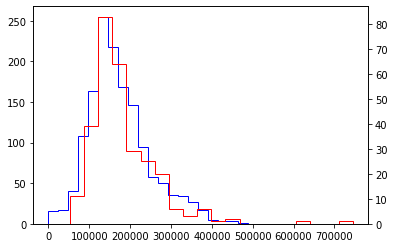

In [198]:
plt.hist(yhat_rtest, bins=20, histtype='step', color='blue')
plt2 = plt.twinx()
plt.hist(y3_test * y3_scale, bins=20, histtype='step', color='red')

In [ ]:
def graph_preds(x, y, coefs, axis):
    plt.rcParams['figure.figsize'] = [40, 10]

    import math
    num_columns = 5
    num_rows = math.ceil(x.shape[0] / num_columns)
    fig, ax = plt.subplots(num_rows, num_columns)
    for idx, ii in enumerate(x.shape[1]):
        sub_plot = ax[idx // num_columns, idx % num_columns]
        sub_plot.plot(x[:, ii], y, '.')
        sub_plot.set_xlabel(str(axis[ii]))    
        
graph_preds(x_rtest, yhat_rtest)

Writing to  /home/rushi/dev/data/housing/upload/housing_20211222.100834


In [169]:
!cat $file_name

Id,SalePrice
1461,100759.61334002722
1462,173403.18977425917
1463,150260.34978365156
1464,187441.92968892062
1465,195260.4531132268
1466,167354.7465417423
1467,153237.32941255788
1468,153898.76071440114
1469,241160.00405962407
1470,113317.80539512126
1471,190481.53131063425
1472,89051.42992124514
1473,73016.33044550133
1474,147691.9496840901
1475,113576.02907629168
1476,316291.7781780126
1477,263273.6142653327
1478,332095.0730303284
1479,352526.17374443106
1480,389253.41642757045
1481,314295.28033663053
1482,268179.9233773501
1483,160080.8043660655
1484,198803.21835128366
1485,221805.91029014217
1486,205595.36236860766
1487,311800.7310221098
1488,207488.1662589818
1489,194058.48649728036
1490,187072.80082092356
1491,210303.8680296933
1492,84835.63778462948
1493,223880.24918871603
1494,302331.0596102204
1495,297010.7524213656
1496,226131.1996696144
1497,173950.65309427909
1498,194313.2412260742
1499,158314.1533803666
1500,140597.05567620514
1501,163521.9530191768
1502,170648.69150737533

In [170]:
def display(x, y, corrs, axis):
    plt.rcParams['figure.figsize'] = [40, 10]

    num_rows = 3
    num_columns = 5
    fig, ax = plt.subplots(num_rows, num_columns)
    for idx, ii in enumerate(corrs[:num_rows * num_columns]):
        sub_plot = ax[idx // num_columns, idx % num_columns]
        sub_plot.plot(x[:, ii], y, '.')
        sub_plot.set_xlabel(str(axis[ii]))    

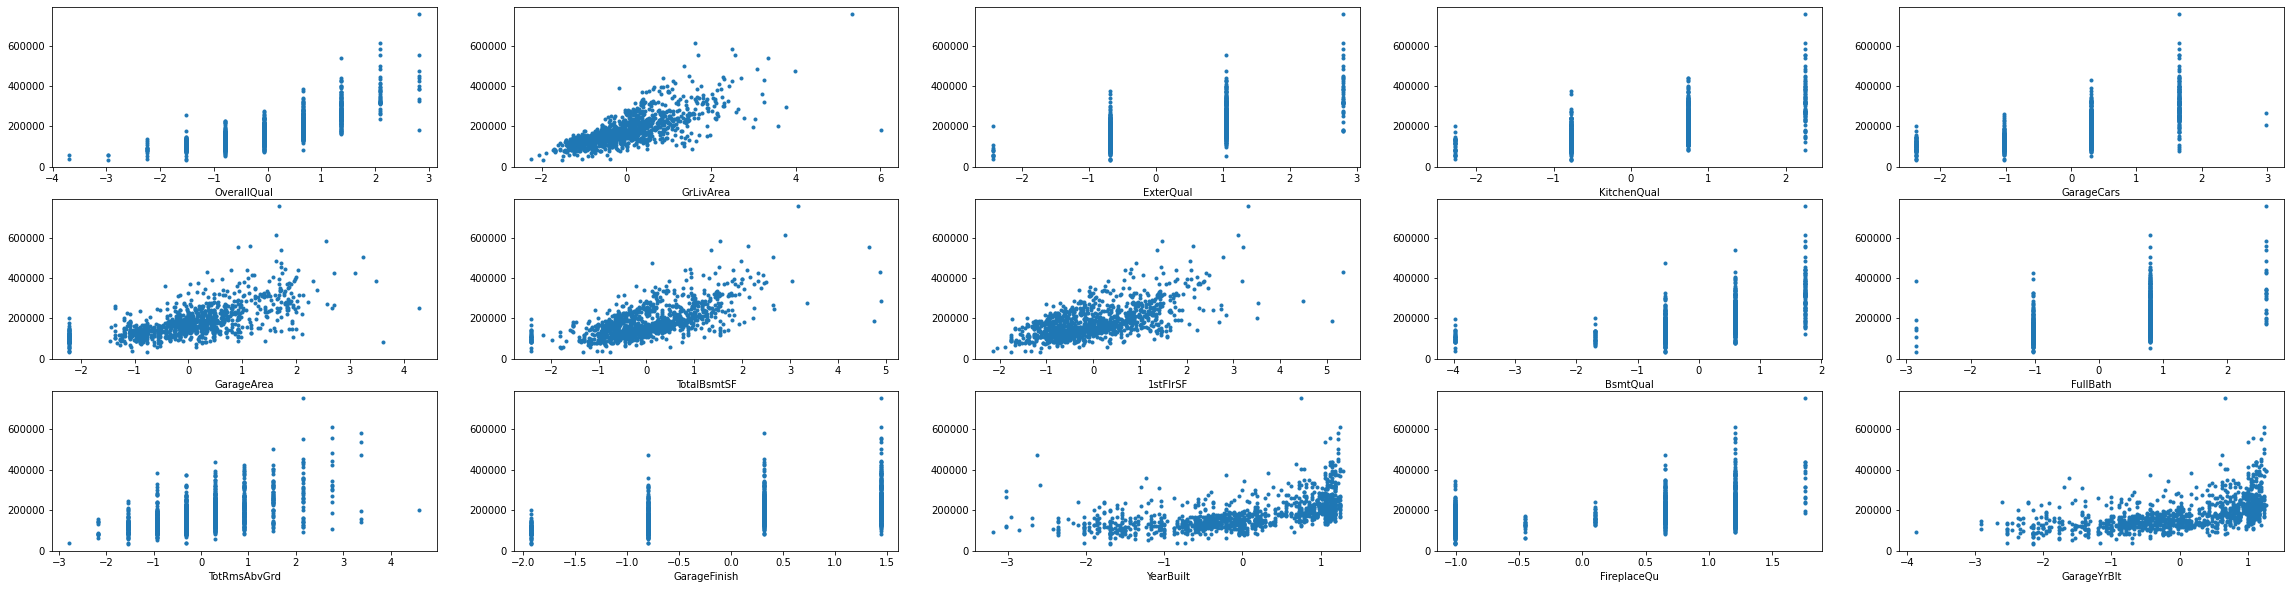

In [30]:
display(x3_train, y3_train, largest_corrs_v3, axis_v3)